# data preparation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, MinMaxScaler
color_pal = sns.color_palette()

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.initializers import GlorotUniform

In [5]:
df = pd.read_csv("/Users/pietrocosseddu/Desktop/Tirocinio/Approccio robusto/anonymized_costs.csv")

# Define the MeterCategories you want to select as a list
#desired_meter_categories = ['Storage', 'Virtual Machines', 'Automation', 'Bandwidth', 'Load Balancer', 'Log Analytics', 'Service Bus', 'Logic Apps']  # Add your desired categories

# Select rows where 'MeterCategory' matches the desired names
#df = df[df['MeterCategory'].isin(desired_meter_categories)]

# Rest of your data processing code
columns_to_eliminate = ['InvoiceSectionName', 'MeterCategory', 'MeterSubCategory', 'MeterName', 'SubscriptionName', 'ResourceGroup', 'ConsumedService', 'ResourceLocation', 'ResourceName']

# Mapping categorical features (if needed)

df.drop(columns=columns_to_eliminate, inplace=True)
df = df.set_index("Date")
df.index = pd.to_datetime(df.index)

df['DayOfWeek'] = df.index.day_of_week
df['Month'] = df.index.month

df['CostInBillingCurrency'] = df.groupby(df.index.date)['CostInBillingCurrency'].sum()
df = df.drop_duplicates(subset=['CostInBillingCurrency'])
df = df.sort_index()
df.shape

FileNotFoundError: [Errno 2] No such file or directory: '/Users/pietrocosseddu/Desktop/Tirocinio/Approccio robusto/anonymized_costs.csv'

In [3]:
def directional_accuracy(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate the sign of the difference between consecutive actual values
    actual_diff = np.sign(y_true[1:] - y_true[:-1])
    
    # Calculate the sign of the difference between the predicted value and the actual value of the previous day
    pred_diff = np.sign(y_pred[1:] - y_true[:-1])
    
    # Calculate the number of times the signs are the same
    num_correct = np.sum(actual_diff == pred_diff)
    
    # Calculate the total number of comparisons (which is one less than the length of the time series)
    total_comparisons = len(y_true) - 1
    
    # Calculate the directional accuracy
    da = num_correct / total_comparisons
    
    return da

In [4]:
def custom_loss(y_true, y_pred):

    rmse_w = 1
    da_w = 1

    # Calculate RMSE
    rmse = K.sqrt(K.mean(K.square(y_pred - y_true)))
    
    # Calculate directional accuracy
    actual_diff = K.sign(y_true[1:] - y_true[:-1])
    pred_diff = K.sign(y_pred[1:] - y_true[:-1])
    num_correct = K.sum(K.cast(K.equal(actual_diff, pred_diff), tf.float32))
    total_comparisons = K.cast(K.shape(y_true)[0] - 1, tf.float32)
    da = num_correct / total_comparisons
    da = 1-da

    # Normalize RMSE and directional accuracy
    rmse_normalized = rmse / (K.max(y_true) - K.min(y_true))
    
    # Combine normalized RMSE and directional accuracy with weights
    loss = (rmse_normalized * rmse_w) + (da * da_w)
    
    return loss

In [5]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
    return np.array(X)

In [6]:
def add_element(data, element):
  DataSet = np.empty((data.shape[0], data.shape[1] + 1))
  for i in range(data.shape[0]):
      nuova_riga = np.append(data[i], element[i])
      DataSet[i] = nuova_riga
  return DataSet

# data split and training

In [7]:
scaler = MinMaxScaler()
prova = scaler.fit_transform(df)

In [19]:
seq_length = 6
data = df['CostInBillingCurrency'].values
data = create_sequences(data, seq_length)

week = df['DayOfWeek'][seq_length:].values
month = df['Month'][seq_length:].values
data = data.reshape(len(data), seq_length)

data = add_element(data, week)
data = add_element(data, month)

Y = df['CostInBillingCurrency'][seq_length:].values

walk_train_x = []
walk_val_x = []
walk_test_x = []

walk_train_y = []
walk_val_y = []
walk_test_y = []

Compare_df = pd.DataFrame()
Compare_df['Ground_truth'] = df['CostInBillingCurrency'][-26:]
Compare_df['predictions'] = 0

delay = 0

if (seq_length == 4):
    start = 50
elif (seq_length == 2):
    start = 52
elif (seq_length == 6):
    start = 48

# divisione dei passi
for i in range (5):

    delay = i*5

    walk_train_x.append(data[delay:start+delay])
    walk_val_x.append(data[start+delay:start+10+delay])
    walk_test_x.append(data[start+10+delay:start+15+delay])

    walk_train_y.append(Y[delay:start+delay])
    walk_val_y.append(Y[start+delay:start+10+delay])
    walk_test_y.append(Y[start+10+delay:start+15+delay])


In [9]:
def compute_rmse(predictions, truth):
    rmse = []
    for i in range(len(predictions)):
        rmse.append(np.sqrt(mean_squared_error(truth[i], predictions[i])))
    result = sum(rmse)/len(rmse)
    return result

In [20]:
MDA_VAL = []
MDA_TEST = []
MODELS = []
HISTORYS = []
RMSE_VAL = []
RMSE_TEST = []

predizioni_test = []
predizioni_val = []

for i in range(10):

    walk_pred_test = []
    walk_pred_val = []
    walk_history = []
    walk_mda_test = []
    walk_mda_val = []

    history = 0 

    model = Sequential()
    model.add(InputLayer((8, 1)))
    model.add(LSTM(256, activation='relu', return_sequences=True))
    model.add(LSTM(128, activation='relu', return_sequences=True))
    model.add(LSTM(64, activation='relu', return_sequences=True))
    model.add(LSTM(64, activation='relu'))
    model.add(Dense(1))

    model.summary()

    cp = ModelCheckpoint("model/", save_best_only=True, verbose = False)
    model.compile(loss=custom_loss, optimizer=Adam(learning_rate=0.01), metrics=[custom_loss])

    for i in range(5):

        history = model.fit(walk_train_x[i], walk_train_y[i], validation_data=(walk_val_x[i], walk_val_y[i]), epochs = 50, batch_size = 5, callbacks=[cp], verbose = False)

        #extracting the loss value both for training and validation
        history_dict = history.history
        walk_history.append(history_dict)
        
        #I calculate the predictions and I compute tha directional accuracy on val set in order to then choose the best model to test on the test set
        model = tf.keras.models.load_model('model', custom_objects={'custom_loss': custom_loss})
        walk_pred_test.append(model.predict(walk_test_x[i]))
        walk_pred_val.append(model.predict(walk_val_x[i]))
        walk_mda_test.append(directional_accuracy(walk_test_y[i],walk_pred_test[i].reshape(5)))
        walk_mda_val.append(directional_accuracy(walk_val_y[i],walk_pred_val[i].reshape(10)))

    predizioni_test.append(walk_pred_test)
    predizioni_val.append(walk_pred_val)
    MODELS.append(model)
    MDA_VAL.append(sum(walk_mda_val)/len(walk_mda_val))
    MDA_TEST.append(sum(walk_mda_test)/len(walk_mda_test))
    HISTORYS.append(walk_history)
    RMSE_TEST.append(compute_rmse(walk_pred_test, walk_test_y))
    RMSE_VAL.append(compute_rmse(walk_pred_val, walk_val_y))

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_40 (LSTM)              (None, 8, 256)            264192    
                                                                 
 lstm_41 (LSTM)              (None, 8, 128)            197120    
                                                                 
 lstm_42 (LSTM)              (None, 8, 64)             49408     
                                                                 
 lstm_43 (LSTM)              (None, 64)                33024     
                                                                 
 dense_10 (Dense)            (None, 1)                 65        
                                                                 
Total params: 543809 (2.07 MB)
Trainable params: 543809 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
INFO:tensorflow:A

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 13ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 17ms/step
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_44 (LSTM)              (None, 8, 256)            264192    
                                                                 
 lstm_45 (LSTM)              (None, 8, 128)            197120    
                                                                 
 lstm_46 (LSTM)              (None, 8, 64)             49408     
                                                                 
 lstm_47 (LSTM)              (None, 64)                33024     
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 543809 (2.07 MB)
Trainable params: 543809 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________________

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 13ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 13ms/step
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_48 (LSTM)              (None, 8, 256)            264192    
                                                                 
 lstm_49 (LSTM)              (None, 8, 128)            197120    
                                                                 
 lstm_50 (LSTM)              (None, 8, 64)             49408     
                                                                 
 lstm_51 (LSTM)              (None, 64)                33024     
                                                                 
 dense_12 (Dense)            (None, 1)                 65        
                                                                 
Total params: 543809 (2.07 MB)
Trainable params: 543809 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________________

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 13ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 14ms/step
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_52 (LSTM)              (None, 8, 256)            264192    
                                                                 
 lstm_53 (LSTM)              (None, 8, 128)            197120    
                                                                 
 lstm_54 (LSTM)              (None, 8, 64)             49408     
                                                                 
 lstm_55 (LSTM)              (None, 64)                33024     
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                                                                 
Total params: 543809 (2.07 MB)
Trainable params: 543809 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________________

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 15ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 14ms/step
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_56 (LSTM)              (None, 8, 256)            264192    
                                                                 
 lstm_57 (LSTM)              (None, 8, 128)            197120    
                                                                 
 lstm_58 (LSTM)              (None, 8, 64)             49408     
                                                                 
 lstm_59 (LSTM)              (None, 64)                33024     
                                                                 
 dense_14 (Dense)            (None, 1)                 65        
                                                                 
Total params: 543809 (2.07 MB)
Trainable params: 543809 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________________

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 15ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 14ms/step
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_60 (LSTM)              (None, 8, 256)            264192    
                                                                 
 lstm_61 (LSTM)              (None, 8, 128)            197120    
                                                                 
 lstm_62 (LSTM)              (None, 8, 64)             49408     
                                                                 
 lstm_63 (LSTM)              (None, 64)                33024     
                                                                 
 dense_15 (Dense)            (None, 1)                 65        
                                                                 
Total params: 543809 (2.07 MB)
Trainable params: 543809 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________________

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 14ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 14ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 14ms/step
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_64 (LSTM)              (None, 8, 256)            264192    
                                                                 
 lstm_65 (LSTM)              (None, 8, 128)            197120    
                                                                 
 lstm_66 (LSTM)              (None, 8, 64)             49408     
                                                                 
 lstm_67 (LSTM)              (None, 64)                33024     
                                                                 
 dense_16 (Dense)            (None, 1)                 65        
                                                                 
Total params: 543809 (2.07 MB)
Trainable params: 543809 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________________

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 15ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 15ms/step
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_68 (LSTM)              (None, 8, 256)            264192    
                                                                 
 lstm_69 (LSTM)              (None, 8, 128)            197120    
                                                                 
 lstm_70 (LSTM)              (None, 8, 64)             49408     
                                                                 
 lstm_71 (LSTM)              (None, 64)                33024     
                                                                 
 dense_17 (Dense)            (None, 1)                 65        
                                                                 
Total params: 543809 (2.07 MB)
Trainable params: 543809 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________________

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 14ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 20ms/step
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_72 (LSTM)              (None, 8, 256)            264192    
                                                                 
 lstm_73 (LSTM)              (None, 8, 128)            197120    
                                                                 
 lstm_74 (LSTM)              (None, 8, 64)             49408     
                                                                 
 lstm_75 (LSTM)              (None, 64)                33024     
                                                                 
 dense_18 (Dense)            (None, 1)                 65        
                                                                 
Total params: 543809 (2.07 MB)
Trainable params: 543809 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________________

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 14ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 14ms/step
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_76 (LSTM)              (None, 8, 256)            264192    
                                                                 
 lstm_77 (LSTM)              (None, 8, 128)            197120    
                                                                 
 lstm_78 (LSTM)              (None, 8, 64)             49408     
                                                                 
 lstm_79 (LSTM)              (None, 64)                33024     
                                                                 
 dense_19 (Dense)            (None, 1)                 65        
                                                                 
Total params: 543809 (2.07 MB)
Trainable params: 543809 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________________

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 16ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 21ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 17ms/step


In [26]:
MDA_VAL

[0.5555555555555556,
 0.6,
 0.6,
 0.6444444444444444,
 0.5777777777777777,
 0.6444444444444443,
 0.6444444444444445,
 0.5777777777777777,
 0.5555555555555556,
 0.6]

In [22]:
MDA_TEST

[0.4, 0.45, 0.45, 0.4, 0.4, 0.4, 0.45, 0.45, 0.45, 0.4]

In [23]:
RMSE_TEST[6]

17.306812206668447

In [132]:
def reshape_predictions(predictions_list):
    predictions_list = np.array(predictions_list)
    predictions_list = predictions_list.reshape(len(predictions_list),25)
    return predictions_list

In [24]:
Compare_df = pd.DataFrame()
Compare_df['Ground_truth'] = df['CostInBillingCurrency'][-26:]

p = np.array(predizioni_test[6])
p = np.insert(p, 0, Compare_df['Ground_truth'][0])

Compare_df['predictions'] = p
Compare_df

,Ground_truth,predictions
Date,,
2023-02-23,110.306381,110.306381
2023-02-24,108.557959,134.628494
2023-02-25,107.925850,131.294067
2023-02-26,103.073215,125.639320
2023-02-27,110.290543,119.462685
2023-02-28,102.686326,116.599304
2023-03-01,81.475006,100.712044
2023-03-02,78.840089,99.377197
2023-03-03,93.283237,97.869743


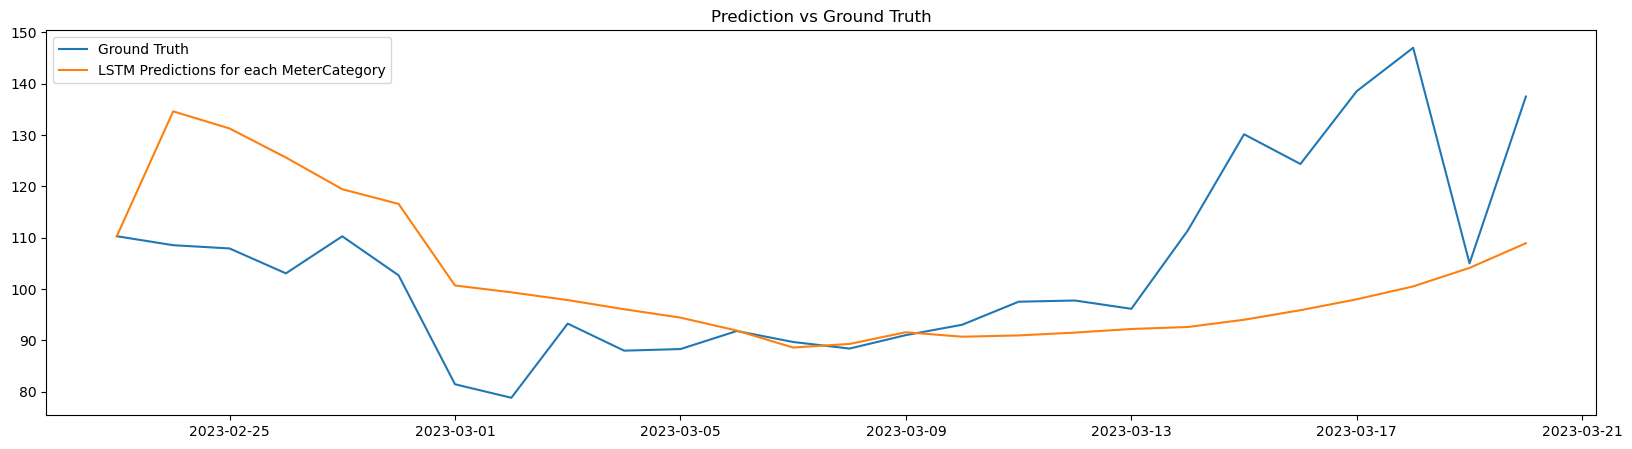

MDA = 0.48
RMSE = 17.306812206668447


In [25]:
pred_data = Compare_df['predictions']
truth_data = Compare_df['Ground_truth']

# Create the plot
plt.figure(figsize=(20, 5))
plt.plot(truth_data, label="Ground Truth")
plt.plot(pred_data, label="LSTM Predictions for each MeterCategory")

# Add title and legends
plt.title("Prediction vs Ground Truth")
plt.legend()

# Display the plot
plt.show()

print("MDA =",directional_accuracy(truth_data,pred_data))
print("RMSE =",RMSE_TEST[6])